# Exercise 4: Image classification

## 1. Install dependencies, if needed

Run the commands below to install the dependencies

In [1]:
!pip install -q pillow matplotlib scikit-image scikit-learn gdown

## 2. Extract regions and features

- Download the images by running the next cell 

In [2]:
import gdown
import os
import zipfile

if not os.path.exists("images_week4"):
    id = "1n8wf8K7LK_F8q1SUBQB3HX7eWtumySfc"
    gdown.download(id=id, output="images_week4.zip", quiet=True)
    with zipfile.ZipFile("images_week4.zip", 'r') as zip_ref:
        zip_ref.extractall()

Alternatively, you can download it directly from [here](https://drive.google.com/file/d/1n8wf8K7LK_F8q1SUBQB3HX7eWtumySfc/view?usp=sharing) via the browser and unzip in this folder.

- The zip file contains the following subfolders:
    - images
    - gt: Ground truth (GT) labels for each pixel of the image, labeled with the following classes
        - 0. Impervious
        - 1. Building
        - 2. Low vegetation
        - 3. Tree
- Run the code block of functions that extract features (it is the same code you implemented in the past exercise)
- Extract and save regions for each image using SLIC (use the parameter n_segments=1000)
- Extract and save features for the regions of each image

warmup: let's load the images and display them again

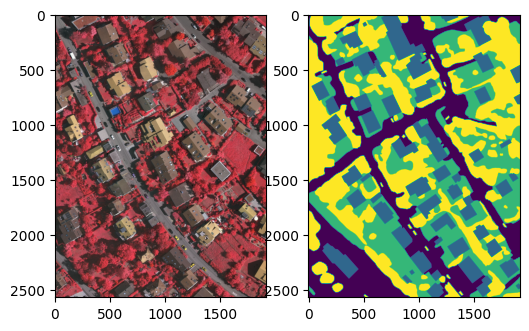

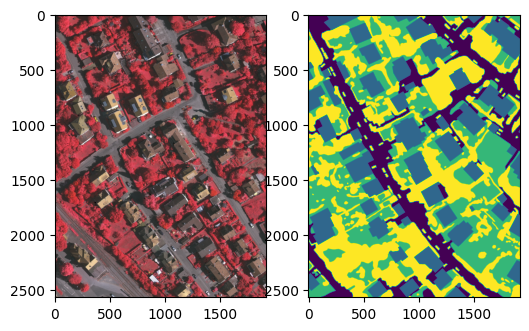

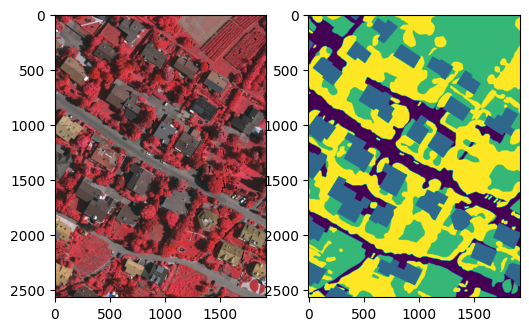

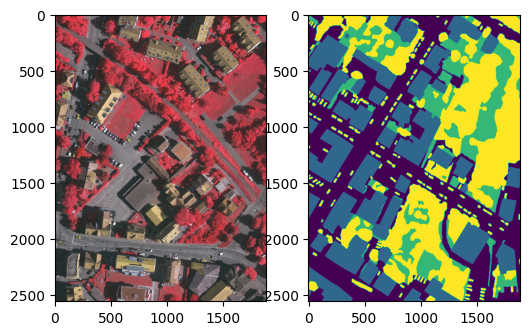

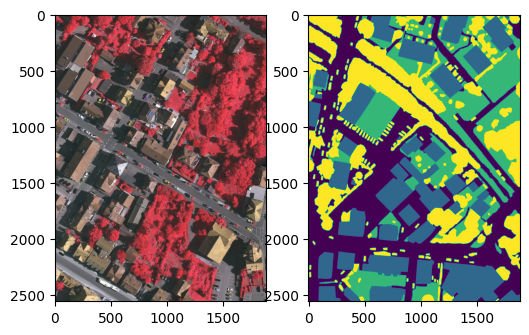

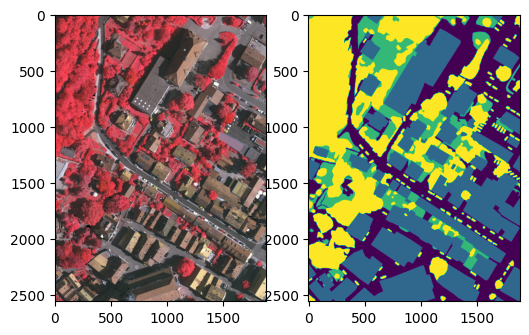

In [3]:
import matplotlib.pyplot as plt # for plotting
from skimage.io import imsave, imread # to read and save images
import os # to list and search folders

# TODO: list all files within the "images" subfolder and within the "gt"
images_list = os.listdir(f"images_week4/images")
ground_truth_list = os.listdir(f"images_week4/gt")

for image_filename, ground_truth_filename in zip(images_list, ground_truth_list):
    fig, axs = plt.subplots(1,2, figsize=(6,4))
    
    # first subplot
    ax = axs[0]
    
    # TODO: specify the path to this image file
    image = imread(f"images_week4/images/{image_filename}")
    
    ax.imshow(image)
    
    # second subplot
    ax = axs[1]
    
    # TODO: specify the path to this ground truth file
    image = imread(f"images_week4/gt/{ground_truth_filename}")
    
    ax.imshow(image)

In [4]:
# The following functions are the same you implemented the past week
# You do not need to edit the functions of this code block (just run it)
def convert_to_shape_pixels_by_bands(data):
    num_dimensions = len(data.shape)
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[2]
        return data.reshape((-1, num_bands))
    else:
        return data

def compute_average_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    avg_features = np.mean(data_2d, axis=0)
    return avg_features

def compute_standard_deviation_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    avg_features = np.std(data_2d, axis=0)
    return avg_features

def compute_histogram_feature(data, num_bins=10):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    hist_features = np.zeros((num_bands, num_bins)).astype(np.float32)
    for b in range(num_bands):
        # Compute the histogram for each band 
        #       use the function np.histogram(array, bins=num_bins)
        hist, boundaries = np.histogram(data_2d[:, b], bins=num_bins)
        hist_features[b, :] = hist
    # Return a 1D array containing all the values
    return hist_features.flatten()

def compute_image_features_from_regions(image, segmentation_map):
    num_regions = len(np.unique(segmentation_map))
    all_features = []
    for id_region in range(num_regions):
        # Obtain pixel values of each regions, with shape (num_pixels x num_bands)
        pixel_values = image[segmentation_map==id_region]
        # Compute the average, standard deviation and histogram features
        #       and concatenated them unsing the function (np.concatenate)
        avg = compute_average_feature(pixel_values)
        features = compute_standard_deviation_feature(pixel_values)
        hist_features = compute_histogram_feature(pixel_values)
        features = np.concatenate([avg, features, hist_features])
        # Add concatenated features to the variable all_features
        all_features.append(features)
    # convert list to numpy array of shape: (num_regions x num_bands)
    return np.array(all_features).astype(np.float32)

Let's extract regions and their features (average, standard deviation and histogram of each band)

1. use the [slic](https://scikit-image.org/docs/dev/api/skimage.segmentation.html?highlight=slic#skimage.segmentation.slic) algorithm from skimage
2. use `compute_image_features_from_regions` to extract features
3. save numpy arrays with `np.save(filename.npy)` and images with `imsave(filename.tif)`

Tip: you can replace substrings in `text` with `text.replace("a","b")` this will be useful when renaming files (e.g. `images_1.tif` to `regions_1.tif`)

In [5]:
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import os

for image_filename in images_list:
    
    # TODO: Read image
    image_path = f"images_week4/images/{image_filename}"
    image = imread(image_path)
    
    # TODO: Segment image using SLIC (use the parameter n_segments=1000)
    segmented_image = slic(image, n_segments=1000, start_label=0)
    
    # Save SLIC regions with imsave (e.g. in images_week4/images/regions_*.tif)
    # rename images_1.tif -> regions_1.tif
    regions_filename = image_filename.replace("image","regions")
    regions_path = f"images_week4/regions/{regions_filename}"
    imsave(regions_path, segmented_image.astype(np.uint32))
    print("regions saved in " + regions_path)
    
    # TODO: Compute features
    region_features = compute_image_features_from_regions(image, segmented_image)
    
    # Save features
    # rename images_1.tif -> features_1.npy
    features_filename = image_filename.replace("image","features").replace(".tif",".npy")
    region_features_path = f"images_week4/features/{features_filename}"
    np.save(region_features_path, region_features)
    print(f"features saved in {region_features_path}")

/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_5.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_5.tif
features saved in images_week4/features/features_5.npy


/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_4.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_4.tif
features saved in images_week4/features/features_4.npy


/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_6.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_6.tif
features saved in images_week4/features/features_6.npy


/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_3.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_3.tif
features saved in images_week4/features/features_3.npy


/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_2.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_2.tif
features saved in images_week4/features/features_2.npy


/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/2086718155.py:19: UserWarning: images_week4/regions/regions_1.tif is a low contrast image
  imsave(regions_path, segmented_image.astype(np.uint32))


regions saved in images_week4/regions/regions_1.tif
features saved in images_week4/features/features_1.npy


## 3. Create training dataset
- Define which images will be in the training set, and which ones the test set
- Read the images from the training set and compute the ideal label for each region (the label that has the largest intersection with each region)
- Create an array of targets (groud truth), per region, that combines the targets of all the training images
- Create an array of features that combines the features of all the training images

In [6]:
# TODO: split images randomly into training and testing partitions

# fixing seed to have same results
np.random.seed(0)

# list of all image numbers
all_image_numbers = [1, 2, 3, 4, 5, 6]

# TODO: choose 3 entries randomly for the training set
train_image_numbers = np.random.choice(all_image_numbers, 
                                       size=3, 
                                       replace=False)

# TODO: select other 3 for the test set. Make sure there is no overlap
test_image_numbers = []
for i in all_image_numbers:
    if i not in train_image_numbers:
        test_image_numbers.append(i)
        
# alternative one liner
test_image_numbers = [i for i in all_image_numbers 
                      if i not in train_image_numbers]
        
# optional convert list into array
test_image_numbers = np.array(test_image_numbers)

print(train_image_numbers)
print(test_image_numbers)

[6 3 2]
[1 4 5]


In [7]:
def get_label_per_region(segmented_image, label_map):
    """
    Returns a 1D numpy array that contains the label for each region, shape: (num_regions)
            For each region, we obtain the label that has the largest intersection with it
    """
    num_regions = len(np.unique(segmented_image))
    num_labels = len(np.unique(label_map))
    region_labels = []
    for region_id in range(num_regions):
        mask_region = segmented_image == region_id
        
        intersection_per_label = []
        for label_id in range(num_labels):
            mask_label = label_map == label_id
            # Compute intersection of each region with each label
            intersection = np.sum(mask_region * mask_label)
            intersection_per_label.append(intersection)
        
        intersection_per_label = np.array(intersection_per_label)
        # Obtain the index of the label with largest intersection
        selected_label = np.argmax(intersection_per_label)
        region_labels.append(selected_label)
    
    return np.array(region_labels).astype(np.uint32)

In [8]:
import numpy as np
from tqdm.auto import tqdm # progress bar

# Create arrays of training targets and features 
all_train_region_features = []
all_train_region_labels = []

for image_number in tqdm(train_image_numbers):
    # TODO: read segmented image
    segmented_image_path = f"images_week4/regions/regions_{image_number}.tif"
    segmented_image = imread(segmented_image_path)
    # TODO: read ground truth image
    gt_path = f"images_week4/gt/gt_{image_number}.tif"
    gt_image = imread(gt_path)
    # TODO: Get labels per region using the function "get_label_per_region" defined above
    region_labels = get_label_per_region(segmented_image, gt_image)
    # Add current region labels to the variable all_train_region_labels
    all_train_region_labels.append(region_labels)
    # TODO: read features using the function: np.load(file_path.npy)
    region_features_path = f"images_week4/features/features_{image_number}.npy"
    region_features = np.load(region_features_path)
    # Add current region features to the variable all_train_region_features
    all_train_region_features.append(region_features)

# Tranforming the list all_train_region_labels in an array of shape: (num_all_regions)
train_labels = np.concatenate(all_train_region_labels)
print("train_labels shape " + str(train_labels.shape))
# Tranforming the list all_train_region_features in an array of shape: (num_all_regions, num_features)
train_features = np.concatenate(all_train_region_features)
print("train_features shape " + str(train_features.shape))

  0%|          | 0/3 [00:00<?, ?it/s]

train_labels shape (1976,)
train_features shape (1976, 36)


## 4. Normalize features

Normalize features by substracting the mean and dividing by the standard deviation

In [9]:
mean_per_feature = np.mean(train_features, axis=0)
std_per_feature = np.std(train_features, axis=0)
# TODO: normalize features by substracting the mean and dividing by the standard deviation
norm_train_features = (train_features - mean_per_feature) / std_per_feature

## 5. Train Random Forest classifier

Train model using the ***sklearn*** library

In [10]:
from sklearn.ensemble import RandomForestClassifier

# TODO: create random forest classifier with the parameter random_state=10
classifier = RandomForestClassifier(random_state=10)
# TODO: fit the model with the normalized features
classifier.fit(norm_train_features, train_labels)

RandomForestClassifier(random_state=10)

## 6. Predict classification map for test images

For each image in the test set
- Load features
- Predict labels by region
- Predict labels for each pixel
- Save the predictions on disk

In [11]:
for image_number in test_image_numbers:
    # TODO: read segmented image
    segmented_image_path = f"images_week4/regions/regions_{image_number}.tif"
    segmented_image = imread(segmented_image_path)
    # TODO: read features using the function: np.load(file_path.npy)
    region_features_path = f"images_week4/features/features_{image_number}.npy"
    region_features = np.load(region_features_path)
    # TODO: normalize features by substracting the mean and dividing by the standard deviation (of the train set) 
    norm_region_features = (region_features - mean_per_feature) / std_per_feature
    # TODO: predict label of regions 
    label_predictions = classifier.predict(norm_region_features)
    # Compute label predictions per pixel
    prediction_map = np.zeros(segmented_image.shape).astype(np.uint8)
    num_regions = len(np.unique(segmented_image))
    for region_id in range(num_regions):
        # TODO: set the label predicted for a region to all the pixels of that region
        prediction_map[segmented_image==region_id] = label_predictions[region_id]
    # TODO: Save prediction map image
    prediction_map_path = f"images_week4/prediction_map_{image_number}.tif"
    imsave(prediction_map_path, prediction_map)

/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/234236701.py:20: UserWarning: images_week4/prediction_map_1.tif is a low contrast image
  imsave(prediction_map_path, prediction_map)
/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/234236701.py:20: UserWarning: images_week4/prediction_map_4.tif is a low contrast image
  imsave(prediction_map_path, prediction_map)
/var/folders/56/hvnxfbdn7qqb35_4nr4c3pkh0000gn/T/ipykernel_2174/234236701.py:20: UserWarning: images_week4/prediction_map_5.tif is a low contrast image
  imsave(prediction_map_path, prediction_map)


## 7. Visualize predictions

Visualize one of the classification predictions save one disk

In [12]:
import matplotlib.pyplot as plt

def display_label_image(label_map):
    colors = np.array([[255, 255, 255], # Impervious: white
                       [0, 0, 255],     # Building: Blue
                       [0, 255, 255],   # Low vegetation: cyan
                       [0, 255, 0]])    # Tree: green
    colors = colors.astype(np.uint8)
    color_map = np.zeros((label_map.shape[0], label_map.shape[1], 3)).astype(np.uint8)
    for label_id in range(colors.shape[0]):
        color_map[label_map == label_id] = colors[label_id, :]
    plt.figure(figsize = (11,11)) 
    plt.imshow(color_map)

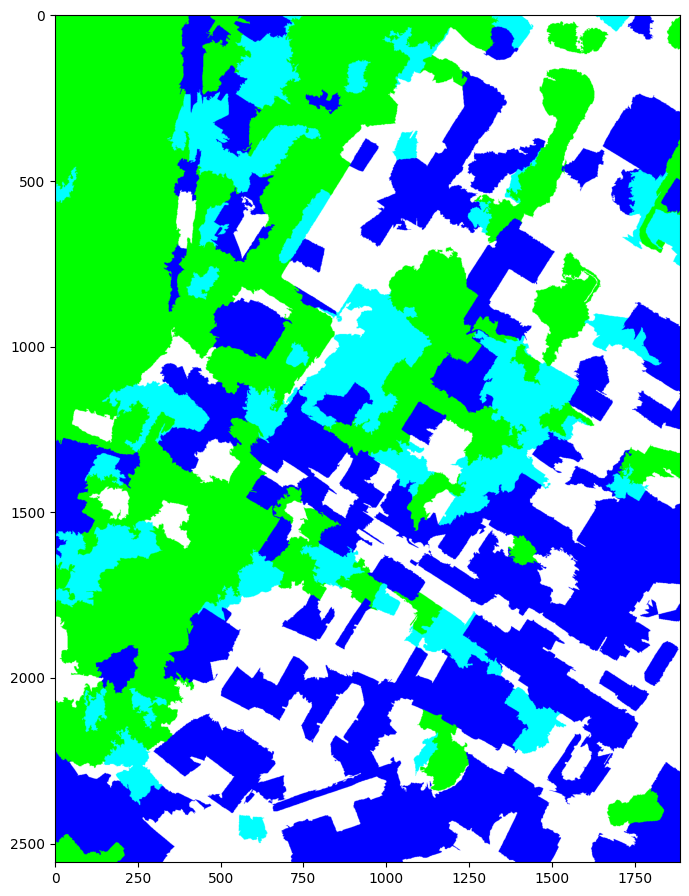

In [13]:
# take first test image
test_image_number = test_image_numbers[0]

# TODO: display one of the prediction map images save on disk (using the function display_label_image, defined above)
example_prediction_path = f"images_week4/prediction_map_{test_image_number}.tif" 
example_prediction = imread(example_prediction_path)
display_label_image(example_prediction)

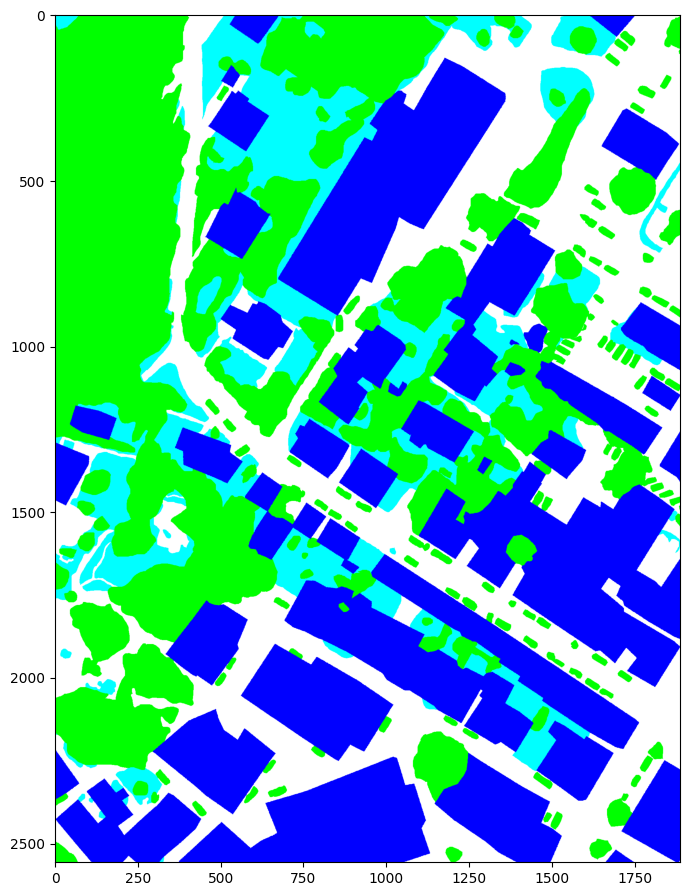

In [14]:
# TODO: Display the ground truth corresponding to the image you visualized above
example_gt_path = f"images_week4/gt/gt_{test_image_number}.tif" 
example_gt = imread(example_gt_path)
display_label_image(example_gt)

## 8. Answer the question and discuss with your neighbor

> Comparing the prediction and the ground truth, which types of errors do you find in the predictions?

Tip: google for Type 1/Type 2 errors if you think it is too straightforward.

Possible answer: There are some false positives for the Impervious class: some buildings and small vegetation patches are segmented as Impervious. Overall all classes seem to have some false positive and false negative preditions.

## Congratulations. You Finished! See you next week